#### Columns

- client_id - идентификатор клиента
- education - уровень образования
- sex - пол заемщика
- age - возраст заемщика
- car - флаг наличия автомобиля
- car_type - флаг автомобиля иномарки
- decline_app_cnt - количество отказанных прошлых заявок
- good_work - флаг наличия “хорошей” работы
- bki_request_cnt - количество запросов в БКИ
- home_address - категоризатор домашнего адреса
- work_address - категоризатор рабочего адреса
- income - доход заемщика
- foreign_passport - наличие загранпаспорта
- sna - связь заемщика с клиентами банка
- first_time - давность наличия информации о заемщике
- score_bki - скоринговый балл по данным из БКИ
- region_rating - рейтинг региона
- app_date - дата подачи заявки
- default - флаг дефолта по кредиту


### IMPORTS

In [253]:
import datetime
import time

from pandas import Series
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve

In [2]:
RANDOM_SEED = 444

In [330]:
# numerical columns
NUM_COLS = ['age', 'decline_app_cnt', 'income', 'bki_request_cnt', 'score_bki', 'bki_request_cnt', 'region_rating']
# binary columns
BIN_COLS = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']
# categorial columns
CAT_COLS = ['education', 'work_address', 'home_address', 'sna', 'first_time']
# we must process this string into a date
DATE_COLS = ['app_date']
# useless column, used only for result prediction
DROP_COLS = ['client_id']
# targets
TARGET_COLS = ['default']

### DATA LOAD

In [482]:
sample_submission_df = pd.read_csv('sample_submission.csv')
test_df = pd.read_csv('test.csv')
train_df = pd.read_csv('train.csv')

### DATASET EXPLORATION

In [10]:
print("Test size: ", test_df.shape)
print("Train size: ", train_df.shape)

Test size:  (36349, 18)
Train size:  (73799, 19)


In [11]:
test_df.sample(5)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport
7878,19530,27JAN2014,UGR,M,41,Y,N,0,0,-1.780155,4,40,1,2,120000,4,4,N
818,23038,30JAN2014,SCH,F,53,N,N,0,0,-1.641446,3,70,1,2,45000,1,2,N
2681,43846,20FEB2014,GRD,M,24,N,N,0,1,-1.713946,3,60,2,3,50000,4,2,N
35166,13405,21JAN2014,SCH,F,28,N,N,0,0,-2.092366,1,60,1,2,30000,2,3,N
14076,94876,11APR2014,GRD,F,38,N,N,1,0,-1.610822,3,40,1,1,42000,1,3,N


In [483]:
test_df['train'] = 0
train_df['train'] = 1

In [484]:
df = train_df.append(test_df, sort=False).reset_index(drop=True)

In [92]:
df.sample(5)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,train
70037,68337,17MAR2014,GRD,M,46,Y,N,0,1,-2.104211,0,60,1,3,15000,1,3,N,0.0,1
58203,88017,04APR2014,SCH,M,41,N,N,0,0,-2.122613,1,50,2,3,30000,4,1,N,0.0,1
37433,100041,17APR2014,UGR,M,31,N,N,0,0,-2.631431,1,60,2,3,35000,2,3,N,0.0,1
22298,76751,24MAR2014,SCH,F,32,N,N,0,1,-1.775263,2,80,2,3,20000,4,1,N,0.0,1
49880,82805,31MAR2014,SCH,F,61,N,N,0,0,-2.091173,1,70,1,3,28000,1,4,N,0.0,1


<AxesSubplot:>

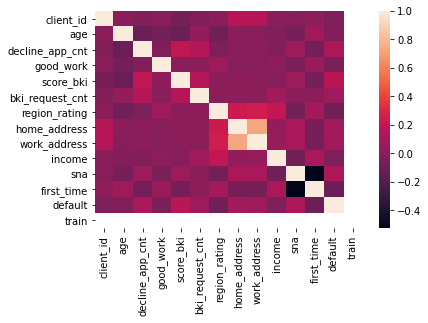

In [485]:
sns.heatmap(df[df['train'] == 1].corr())

<AxesSubplot:xlabel='sna', ylabel='default'>

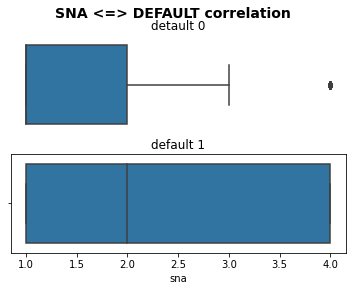

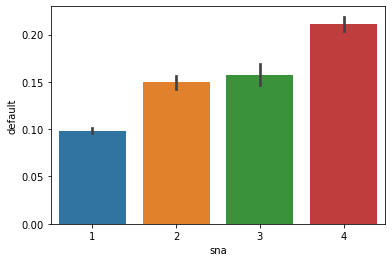

In [486]:
# HIGHER NUMBER OF SNA - increate default risk!
fig = plt.figure()
fig.suptitle('SNA <=> DEFAULT correlation', fontsize=14, fontweight='bold')

ax0 = fig.add_subplot(211)
ax0.set_title('detault 0')
ax0.set_axis_off()
sns.boxplot(df[df['default']== 0].sna, ax=ax0)

ax1 = fig.add_subplot(212)
ax1.set_title('default 1')
sns.boxplot(df[df['default']== 1].sna, ax=ax1)
fig.show()
fig = plt.figure()
ax = fig.add_subplot(111)
sns.barplot(x='sna', y='default', data=df[df['train']== 1], ax=ax)

<AxesSubplot:xlabel='education', ylabel='default'>

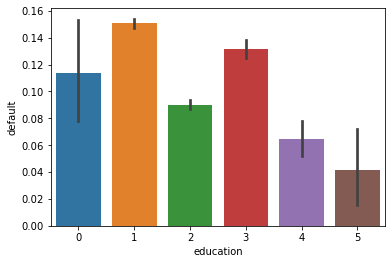

In [487]:
EDUCATION_LABELS = ('NO', 'SCH', 'GRD', 'UGR', 'PGR', 'ACD')
EDUCATION_MAPPING = dict(zip(EDUCATION_LABELS, range(len(EDUCATION_LABELS))))

edu_df = train_df[['education', 'default']]
edu_df.education = edu_df.education.fillna('NO').map(EDUCATION_MAPPING)
sns.barplot(x='education', y='default', data=edu_df)

# as we can see, we must use OneHotEncoder, coz there is no linear correlation between education and default.

### PREPROCESSING

In [488]:
EDUCATION_LABELS = ('NO', 'SCH', 'GRD', 'UGR', 'PGR', 'ACD')
EDUCATION_MAPPING = dict(zip(EDUCATION_LABELS, range(len(EDUCATION_LABELS))))

In [489]:
RESULTING_DATE_COLUMNS = ['month', 'day', 'weekday', 'weekend']
def preprocess_date(row):
    row = row.copy()
    app_date = row.app_date
    row['month'] = app_date.month
    row['day'] = app_date.day
    # useless feature
    # row['year'] = app_date.year
    row['weekday'] = app_date.weekday()
    row['weekend'] = int(row['weekday'] in (5,6))
    return row 


In [490]:
def preprocess(data):
    data = data.copy()
    
    data.education.fillna('NO', inplace=True)
    data.education = data.education.map(EDUCATION_MAPPING)
    
    data.app_date = pd.to_datetime(data.app_date, format='%d%b%Y')
    data = pd.concat([data, pd.DataFrame(columns=RESULTING_DATE_COLUMNS)])
    data = data.apply(preprocess_date, axis=1)
    
    # BIN COLUMNS PROCESSING
    bin_cols = BIN_COLS + ['weekend', ]
    label_encoder = LabelEncoder()
    for column in bin_cols:
        data[column] = label_encoder.fit_transform(data[column])
     
    cat_cols = CAT_COLS + ['weekday',]
    from sklearn.preprocessing import OneHotEncoder
    one_hot = OneHotEncoder(sparse=False)
    data[one_hot.get_feature_names()] = one_hot.fit_transform(data[cat_cols].values)
    
    num_cols = NUM_COLS + ['month', 'day', ]# 'unix']
    data[num_cols] = StandardScaler().fit_transform(data[num_cols].values)
    
    data.drop(columns=cat_cols + ['app_date'], inplace=True)
    return data

### TRAIN

In [491]:
processed_data = preprocess(df)

In [492]:
processed_train = processed_data[processed_data['train'] == 1].drop(['client_id','train'], axis=1)
processed_test = processed_data[processed_data['train'] == 0].drop(['train'], axis=1)

In [493]:
X, y = processed_train[set(processed_train.columns) - {'default'}], processed_train[['default']]

In [494]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=RANDOM_SEED)

In [495]:
model = LogisticRegression(penalty='l2', C=21.5, solver='saga', max_iter=20)
model.fit(X_train, y_train)

LogisticRegression(C=21.5, max_iter=20, solver='saga')

In [496]:
importance = pd.DataFrame(list(zip(X_train.columns, model.coef_[0])), columns=['feature', 'value'])

In [497]:
importance.sort_values(by='value')

,feature,value
27,x1_1.0,-0.516734
16,x2_3.0,-0.503184
15,x2_1.0,-0.483533
21,x3_1.0,-0.477271
31,x4_4.0,-0.432262
6,x0_4.0,-0.401185
20,region_rating,-0.323795
11,x0_2.0,-0.317012
17,car_type,-0.292847
24,x1_2.0,-0.257200


### EVALUATION

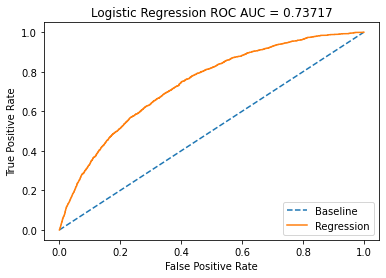

In [498]:
probs = model.predict_proba(X_test)
probs = probs[:,1]

fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.5f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

In [372]:
import warnings
warnings.filterwarnings('ignore')

In [469]:
from sklearn.model_selection import GridSearchCV

penalty = ['l2']
solvers = ['lbfgs', 'liblinear', 'sag', 'saga']
max_iters = range(20, 200, 20)

# Зададим ограничения для параметра регуляризации
C = np.logspace(0, 4, 10)

# Создадим гиперпараметры
hyperparameters = dict(C=C, penalty=penalty, solver=solvers, max_iter=max_iters)

model = LogisticRegression()
model.fit(X_train, y_train)

# Создаем сетку поиска с использованием 5-кратной перекрестной проверки
clf = GridSearchCV(model, hyperparameters, cv=5, verbose=0)

best_model = clf.fit(X_train, y_train)

# View best hyperparameters
print('Лучшее Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Лучшее C:', best_model.best_estimator_.get_params()['C'])

Лучшее Penalty: l2
Лучшее C: 21.544346900318832


In [470]:
best_model.best_estimator_.get_params()

{'C': 21.544346900318832,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 20,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'saga',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

### SUMBISSION

In [499]:
X_submission = processed_test.drop(['client_id', 'default'], axis=1)

In [500]:
X_submission

,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,income,...,x4_2.0,x4_3.0,x4_4.0,x5_0.0,x5_1.0,x5_2.0,x5_3.0,x5_4.0,x5_5.0,x5_6.0
73799,1,-0.889859,1,1,-0.341893,0,-0.735587,0.438921,-0.516704,0.197961,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
73800,0,-0.021654,0,0,5.915180,0,0.800039,-0.002207,-0.516704,-0.793238,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
73801,1,0.933372,1,1,-0.341893,0,0.426908,-0.443335,-0.516704,-0.242572,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
73802,1,1.454295,0,0,-0.341893,0,-0.940432,-0.443335,-1.282058,-0.528918,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
73803,0,-0.108474,0,0,-0.341893,0,-1.167347,-0.884463,1.779355,1.739828,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110143,0,-0.195295,0,0,0.909522,0,0.319505,0.438921,-0.516704,-0.572972,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
110144,0,2.148860,1,1,-0.341893,0,-0.779436,0.438921,0.248649,3.501960,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
110145,1,-0.716218,0,0,2.160936,0,1.929901,-0.443335,-0.516704,0.418228,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
110146,0,-1.063501,0,0,0.909522,0,1.325890,-0.002207,1.779355,-0.242572,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [501]:
y_pred_prob = model.predict_proba(X_submission)[:,1]
submit = pd.DataFrame(test_df.client_id)
submit['default'] = y_pred_prob

In [503]:
submit

,client_id,default
0,74835,0.066600
1,17527,0.234580
2,75683,0.031757
3,26883,0.078508
4,28862,0.131827
...,...,...
36344,83775,0.179170
36345,106254,0.023710
36346,81852,0.039552
36347,1971,0.193557


In [502]:
submit.to_csv('my_submission.csv', index=False)